# Deep Q-Learning for Path Optimization

## Project Overview
This project demonstrates an implementation of Deep Q-Learning (DQN) for solving path optimization problems in grid environments. Specifically, I tackled the CliffWalking environment challenge, a standard reinforcement learning benchmark problem that requires an agent to navigate safely from a starting position to a goal while avoiding hazardous areas.

## Technical Background
The CliffWalking environment represents a grid world where an agent must learn to navigate from the bottom-left corner to the bottom-right corner. The direct path along the bottom edge contains a "cliff" - stepping into this region results in a large negative reward (-100) and immediate reset to the starting position. Each step taken incurs a small negative reward (-1), incentivizing the agent to find the shortest safe path.

## Implementation Details
I implemented a Deep Q-Network (DQN) agent that learns through experience to navigate this environment optimally. The implementation includes:

- Neural network architecture for Q-value function approximation
- Experience replay for efficient learning from past interactions
- Epsilon-greedy exploration strategy with decay over time
- Optimization using Adam optimizer

The agent successfully learns to take the optimal path: moving up from the starting position, traversing the top edge of the grid (safely away from the cliff), and finally moving down to reach the goal.

## Performance Metrics
- Final reward: -13 (optimal value, representing the shortest safe path)
- Convergence achieved within 400 training episodes
- Smooth learning curve demonstrating consistent improvement

## Skills Demonstrated
- Deep Reinforcement Learning implementation
- Neural network design for sequential decision making
- Hyperparameter tuning for optimal performance
- Data visualization for model evaluation

This project showcases my understanding of reinforcement learning principles and practical implementation skills for solving complex sequential decision-making problems.

### Install libraries and initiate a frozen lake map

In [ ]:
# Install gymnasium game environment
!pip install gymnasium
!pip install gymnasium[toy-text]

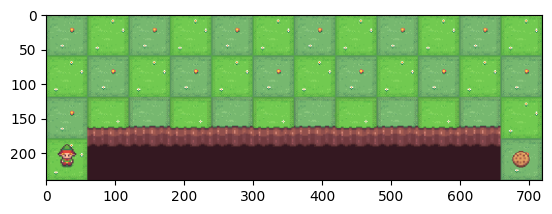

In [ ]:
# Load libraries
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque
import imageio
import pandas as pd


# Initialize the environment\
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
state_size = env.observation_space.n    # Number of states
action_size = env.action_space.n    # Number of actions of this game: four, 0: left, 1:down, 2: right, 3: up.
env.reset()    # Reset environment, i.e., set agent position to state 0
plt.imshow(env.render())    # Visualize environment map

### Solution

In [ ]:
# Define agent attributes and methods
class Agent:
    def __init__(self, state_size, action_size):
      self.memory = deque(maxlen=4096)
      self.batch_size = 64
      self.learning_rate = 0.001
      self.epsilon = 1.0
      self.min_eps = 0.01
      self.eps_decay = 0.00347
      self.gamma = 0.99
      self.state_size = state_size
      self.action_size = action_size
      self.episode = 0
      self.max_steps = 200
      self.train_episodes = 400
      self.policy_model = self.build_model()
    # Build neural network model
    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # Add experience to memory
    def add_memory(self, state, action, reward, new_state, done):
        self.memory.append((state, action, reward, new_state, done))

    # Choose action based on epsilon-greedy policy
    def action(self, state):
        if np.random.rand() > self.epsilon:    # Exploit
            return np.argmax(self.policy_model.predict(state, verbose=0))
        return env.action_space.sample()    # Explore

    # Train policy network with experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample random batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        minibatch_state = np.concatenate(np.array(minibatch, dtype=object)[:, 0], axis=0)
        minibatch_action = np.array(minibatch, dtype=object)[:, 1]
        minibatch_reward = np.array(minibatch, dtype=object)[:, 2]
        minibatch_new_state = np.concatenate(np.array(minibatch, dtype=object)[:, 3], axis=0)
        minibatch_done = np.array(minibatch, dtype=object)[:, 4]

        # Predict current Q-values and next Q-values
        q_state = self.policy_model.predict(minibatch_state, verbose=0)
        q_new_state = self.policy_model.predict(minibatch_new_state, verbose=0)

        # Update Q-values for the actions taken
        for i in range(self.batch_size):
            if minibatch_done[i]:
                q_state[i][minibatch_action[i]] = minibatch_reward[i]
            else:
                q_state[i][minibatch_action[i]] = minibatch_reward[i] + self.gamma * np.max(q_new_state[i])

        # Train the model with updated Q-values
        self.policy_model.fit(minibatch_state, q_state, epochs=1, verbose=0)

    # Save model
    def save_model(self, name):
        self.policy_model.save_weights(name)

    # Load model
    def load_model(self, name):
        self.policy_model.load_weights(name)

In [ ]:
# Initialize agent
agent = Agent(state_size, action_size)
reward_episodes = []    # Track rewards over episodes
step_episodes = []      # Track steps over episodes
epsilon_episodes = []   # Track epsilon over episodes

# Training loop
for episode in range(agent.train_episodes):
    agent.episode = episode
    state = env.reset()[0]    # Reset environment
    state_arr = np.zeros(agent.state_size)
    state_arr[state] = 1
    state_arr = np.reshape(state_arr, [1, agent.state_size])

    total_reward = 0    # Total reward for current episode
    terminated = False
    truncated = False

    img_lst = []
    if episode % 100 == 0:  # Save visualization every 100 episodes
        img_lst = [env.render()]

    for step in range(agent.max_steps):
        action = agent.action(state_arr)    # Choose action
        new_state, reward, terminated, truncated, _ = env.step(action)    # Take action
        total_reward += reward    # Accumulate reward

        # Prepare next state representation
        new_state_arr = np.zeros(agent.state_size)
        new_state_arr[new_state] = 1
        new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])

        # Store experience in memory
        agent.add_memory(state_arr, action, reward, new_state_arr, terminated or truncated)
        state_arr = new_state_arr    # Update current state

        # Render for visualization (every 100 episodes)
        if episode % 100 == 0:
            img = env.render()
            img_lst.append(img)

        # Train the agent
        agent.replay()

        if terminated or truncated:
            break

    # Update epsilon (exploration rate)
    if agent.epsilon > agent.min_eps:
        agent.epsilon = max(agent.min_eps, agent.epsilon * np.exp(-agent.eps_decay))

    # Save visualization as GIF (every 100 episodes)
    if len(img_lst) > 1:
        animation_file = f"cliff_walking_episode_{episode}.gif"
        imageio.mimsave(animation_file, img_lst, format='GIF', duration=0.2)

    # Track metrics
    reward_episodes.append(total_reward)
    step_episodes.append(step + 1)
    epsilon_episodes.append(agent.epsilon)

    # Print progress
    if episode % 10 == 0:
        avg_reward = np.mean(reward_episodes[-10:])
        print(f"Episode: {episode}, Steps: {step + 1}, Epsilon: {agent.epsilon:.3f}, Reward: {total_reward}, Avg Reward (10): {avg_reward:.2f}")

    # Save checkpoint every 20 episodes
    if episode % 20 == 0:
        try:
            checkpoint_filename = f'checkpoint_episode_{episode}.weights.h5'
            agent.policy_model.save_weights(checkpoint_filename)
            print(f"Checkpoint saved: {checkpoint_filename}")
        except Exception as e:
            print(f"Error saving checkpoint at episode {episode}: {e}")

# Try to save the final model
try:
    agent.policy_model.save_weights('cliff_walking_model.weights.h5')
    print("Final model saved successfully")
except Exception as e:
    print(f"Error saving final model: {e}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 0, Steps: 200, Epsilon: 0.997, Reward: -2774, Avg Reward (10): -2774.00
Checkpoint saved: checkpoint_episode_0.weights.h5
Episode: 10, Steps: 200, Epsilon: 0.963, Reward: -794, Avg Reward (10): -1803.80
Episode: 20, Steps: 200, Epsilon: 0.930, Reward: -1091, Avg Reward (10): -1823.40
Checkpoint saved: checkpoint_episode_20.weights.h5
Episode: 30, Steps: 200, Epsilon: 0.898, Reward: -1883, Avg Reward (10): -1711.80
Episode: 40, Steps: 200, Epsilon: 0.867, Reward: -2378, Avg Reward (10): -1537.30
Checkpoint saved: checkpoint_episode_40.weights.h5
Episode: 50, Steps: 97, Epsilon: 0.838, Reward: -394, Avg Reward (10): -1655.10
Episode: 60, Steps: 126, Epsilon: 0.809, Reward: -1215, Avg Reward (10): -1655.50
Checkpoint saved: checkpoint_episode_60.weights.h5
Episode: 70, Steps: 101, Epsilon: 0.782, Reward: -497, Avg Reward (10): -1313.40
Episode: 80, Steps: 175, Epsilon: 0.755, Reward: -1561, Avg Reward (10): -1520.90
Checkpoint saved: checkpoint_episode_80.weights.h5
Episode: 90, 

Text(0.5, 1.0, 'Learning Progress - Rewards')

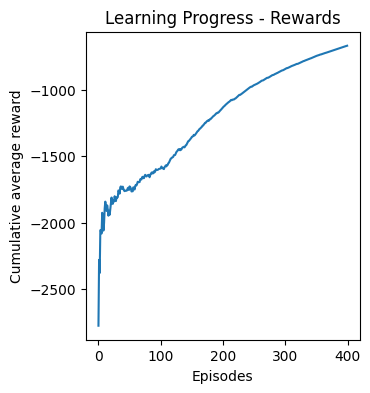

In [ ]:
# Plot training metrics
# 1. Plot cumulative average reward
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
df_reward_episodes = pd.DataFrame(reward_episodes)
cumulative_average_rewards = df_reward_episodes.expanding().mean()
plt.plot(cumulative_average_rewards)
plt.ylabel('Cumulative average reward')
plt.xlabel('Episodes')
plt.title('Learning Progress - Rewards')

Text(0.5, 1.0, 'Learning Progress - Steps')

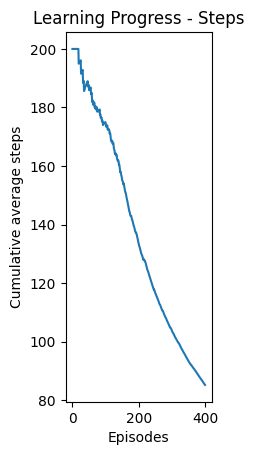

In [ ]:
# 2. Plot cumulative average steps
plt.subplot(1, 3, 2)
df_step_episodes = pd.DataFrame(step_episodes)
cumulative_average_steps = df_step_episodes.expanding().mean()
plt.plot(cumulative_average_steps)
plt.ylabel('Cumulative average steps')
plt.xlabel('Episodes')
plt.title('Learning Progress - Steps')

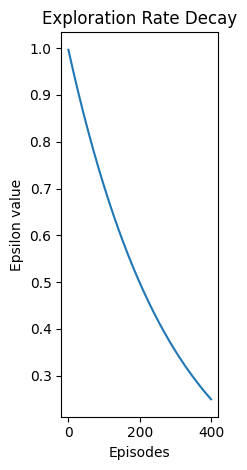

In [ ]:
# 3. Plot epsilon values
plt.subplot(1, 3, 3)
plt.plot(epsilon_episodes)
plt.ylabel('Epsilon value')
plt.xlabel('Episodes')
plt.title('Exploration Rate Decay')

plt.tight_layout()
plt.show()

In [ ]:
# Print the optimal policy
print("\nOptimal Policy (Best action at each state):")
print("0: UP, 1: RIGHT, 2: DOWN, 3: LEFT")

for state_index in range(agent.state_size):
    state_arr = np.zeros(agent.state_size)
    state_arr[state_index] = 1
    state_arr = np.reshape(state_arr, [1, agent.state_size])
    q_values = agent.model.predict(state_arr, verbose=0)
    best_action = np.argmax(q_values)

    row = state_index // 12
    col = state_index % 12

    action_name = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}[best_action]
    print(f"State {state_index} (row {row}, col {col}): Best action = {best_action} ({action_name})")


Optimal Policy (Best action at each state):
0: UP, 1: RIGHT, 2: DOWN, 3: LEFT
State 0 (row 0, col 0): Best action = 1 (RIGHT)
State 1 (row 0, col 1): Best action = 1 (RIGHT)
State 2 (row 0, col 2): Best action = 1 (RIGHT)
State 3 (row 0, col 3): Best action = 2 (DOWN)
State 4 (row 0, col 4): Best action = 1 (RIGHT)
State 5 (row 0, col 5): Best action = 1 (RIGHT)
State 6 (row 0, col 6): Best action = 1 (RIGHT)
State 7 (row 0, col 7): Best action = 2 (DOWN)
State 8 (row 0, col 8): Best action = 1 (RIGHT)
State 9 (row 0, col 9): Best action = 1 (RIGHT)
State 10 (row 0, col 10): Best action = 2 (DOWN)
State 11 (row 0, col 11): Best action = 2 (DOWN)
State 12 (row 1, col 0): Best action = 1 (RIGHT)
State 13 (row 1, col 1): Best action = 1 (RIGHT)
State 14 (row 1, col 2): Best action = 1 (RIGHT)
State 15 (row 1, col 3): Best action = 1 (RIGHT)
State 16 (row 1, col 4): Best action = 1 (RIGHT)
State 17 (row 1, col 5): Best action = 1 (RIGHT)
State 18 (row 1, col 6): Best action = 1 (RIGHT)
St

In [ ]:
# Test the trained agent
state = env.reset()[0]
state_arr = np.zeros(agent.state_size)
state_arr[state] = 1
state_arr = np.reshape(state_arr, [1, agent.state_size])

terminated = False
truncated = False
total_reward = 0
test_steps = 0

img_lst = [env.render()]  # Initialize list to store visualization frames

print("\nTesting the trained agent:")
while not (terminated or truncated) and test_steps < agent.max_steps:
    # Choose best action according to policy
    q_values = agent.policy_model.predict(state_arr, verbose=0)
    action = np.argmax(q_values)

    # Take action
    new_state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    test_steps += 1

    # Prepare next state
    new_state_arr = np.zeros(agent.state_size)
    new_state_arr[new_state] = 1
    new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])

    # Print step information
    row_old = np.argmax(state_arr) // 12
    col_old = np.argmax(state_arr) % 12
    row_new = new_state // 12
    col_new = new_state % 12

    action_name = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}[action]
    print(f"Step {test_steps}: State ({row_old},{col_old}) -> Action {action} ({action_name}) -> State ({row_new},{col_new}), Reward: {reward}")

    state_arr = new_state_arr

    # Render for visualization
    img = env.render()
    img_lst.append(img)

    if terminated or truncated:
        break

print(f"\nTest completed: Total steps = {test_steps}, Total reward = {total_reward}")


Testing the trained agent:
Step 1: State (3,0) -> Action 0 (UP) -> State (2,0), Reward: -1
Step 2: State (2,0) -> Action 1 (RIGHT) -> State (2,1), Reward: -1
Step 3: State (2,1) -> Action 1 (RIGHT) -> State (2,2), Reward: -1
Step 4: State (2,2) -> Action 1 (RIGHT) -> State (2,3), Reward: -1
Step 5: State (2,3) -> Action 1 (RIGHT) -> State (2,4), Reward: -1
Step 6: State (2,4) -> Action 1 (RIGHT) -> State (2,5), Reward: -1
Step 7: State (2,5) -> Action 1 (RIGHT) -> State (2,6), Reward: -1
Step 8: State (2,6) -> Action 1 (RIGHT) -> State (2,7), Reward: -1
Step 9: State (2,7) -> Action 1 (RIGHT) -> State (2,8), Reward: -1
Step 10: State (2,8) -> Action 1 (RIGHT) -> State (2,9), Reward: -1
Step 11: State (2,9) -> Action 1 (RIGHT) -> State (2,10), Reward: -1
Step 12: State (2,10) -> Action 1 (RIGHT) -> State (2,11), Reward: -1
Step 13: State (2,11) -> Action 2 (DOWN) -> State (3,11), Reward: -1

Test completed: Total steps = 13, Total reward = -13


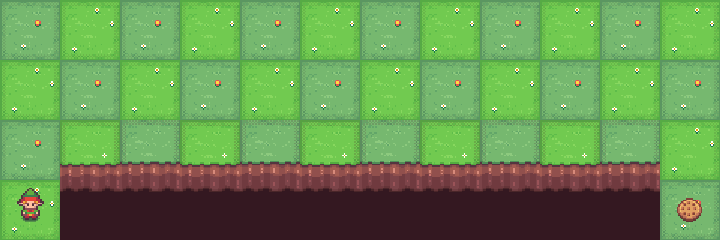

In [ ]:
# Save test visualization
imageio.mimsave('cliff_walking_test.gif', img_lst, format='GIF', duration=0.5)

# Display test result animation
from IPython.display import Image
Image('cliff_walking_test.gif')

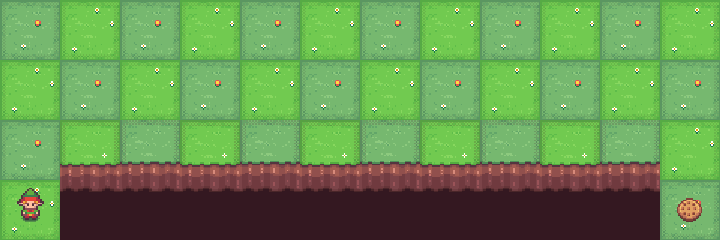

In [ ]:
# Save test visualization with looping enabled
imageio.mimsave('cliff_walking_test.gif', img_lst, format='GIF', duration=0.5, loop=1000)

# Display test result animation
from IPython.display import Image
Image('cliff_walking_test.gif')